# Final Project (part 11)
#### By Shubhankar Kumar

### 8. Similarity analysis across languages

In [4]:
import time
import pyspark
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
sc.stop()

# Waiting for the environment to stop
sleep_time = 30
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '6g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 30 seconds for the enviroment to stop...


23/12/07 19:46:43 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/07 19:46:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/07 19:46:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/07 19:46:43 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 6g


In [5]:
commits_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/finalcommits")

In [6]:
languages_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/shubhankark/languages")

In [7]:
from pyspark.sql.functions import col, explode, sum

# Explode the array of structs to separate rows for each language
exploded_df = languages_df.select("repo_name", explode("language").alias("language_info"))

# Extract language name and bytes from the struct
exploded_df = exploded_df.withColumn("language_name", col("language_info.name"))
exploded_df = exploded_df.withColumn("language_bytes", col("language_info.bytes"))

# Group by repo_name and language, and calculate the sum of bytes for each group
total_bytes_df = exploded_df.groupBy("repo_name", "language_name").agg(sum("language_bytes").alias("total_bytes"))

# Show the result
total_bytes_df.show()

+--------------------+-------------+-----------+
|           repo_name|language_name|total_bytes|
+--------------------+-------------+-----------+
|ibexuk/C_Communic...|            C|      15819|
|kenhys/groonga-to...|        Shell|      23540|
|DaveTCode/2dUltim...|        Shell|         89|
|TheTypoMaster/cal...|            C|     967050|
|         Zaneo/citra|        CMake|      33646|
|PaycoinFoundation...|        Shell|       1854|
|         wgapl/moose|            C|    1487173|
|         wgapl/moose|     Makefile|      63382|
|      smiley22/myPS2|            C|    1656863|
| soundcloud/essentia|       Matlab|      22684|
|     KLHart/Alerting|     Makefile|         63|
|mobilemancer/Droi...|         HTML|      34329|
|forsartis/Project...|           C#|     805300|
|jzeferino/jzeferi...|           C#|      53620|
|      kostyrin/store|          CSS|     196657|
|fbli41/android_ke...|          Lex|      39370|
|   JackyDing/QtFlex4|          C++|     168833|
| dengelke/node-zoom

In [8]:
commits_df = commits_df.withColumn("repo_name", col("repo_name")[0])

merged_df = commits_df.join(total_bytes_df, "repo_name")

In [9]:
merged_df.show(5)

+--------------------+--------------------+--------------------+-------------+-----------+
|           repo_name|             subject|             message|language_name|total_bytes|
+--------------------+--------------------+--------------------+-------------+-----------+
|        0-0-1/cogbot|      UUID Extension|UUID Extension

C...|       Python|      40997|
|0-Eclipse-0/SaltB...|Update and rename...|Update and rename...|    Batchfile|         78|
|0-Eclipse-0/SaltB...|Change the comput...|Change the comput...|    Batchfile|         78|
|0-Eclipse-0/SaltB...|    Delete README.md|    Delete README.md|    Batchfile|         78|
|0-Eclipse-0/SaltB...| Create commands.log| Create commands.log|    Batchfile|         78|
+--------------------+--------------------+--------------------+-------------+-----------+
only showing top 5 rows



In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

In [11]:
selected_languages_df = merged_df.filter(
    col("language_name").isin("C", "JavaScript", "C++", "PHP", "HTML")
)

In [12]:
selected_columns_df = selected_languages_df.select("subject", "message", "language_name")

# Deduplicate based on subject and message
deduplicated_df = selected_columns_df.dropDuplicates(["subject", "message"])


In [13]:
duplicate_counts_df = (
    selected_columns_df
    .groupBy("subject", "message", "language_name")
    .count()
    .filter(col("count") > 1)
)

In [14]:
duplicate_counts_df.show(5)

+---------------+----------------+-------------+-----+
|        subject|         message|language_name|count|
+---------------+----------------+-------------+-----+
| Delete test.py|  Delete test.py|         HTML|   65|
| Update test.md|  Update test.md|   JavaScript|  534|
|          cdag4|          cdag4
|   JavaScript|    2|
|            g16|            g16
|          PHP|    3|
|Canvas resizing|Canvas resizing
|   JavaScript|    2|
+---------------+----------------+-------------+-----+
only showing top 5 rows



In [15]:
aggregate_counts_df = (
    duplicate_counts_df
    .groupBy("language_name")
    .agg({"count": "sum"})
    .withColumnRenamed("sum(count)", "total_duplicate_count")
)

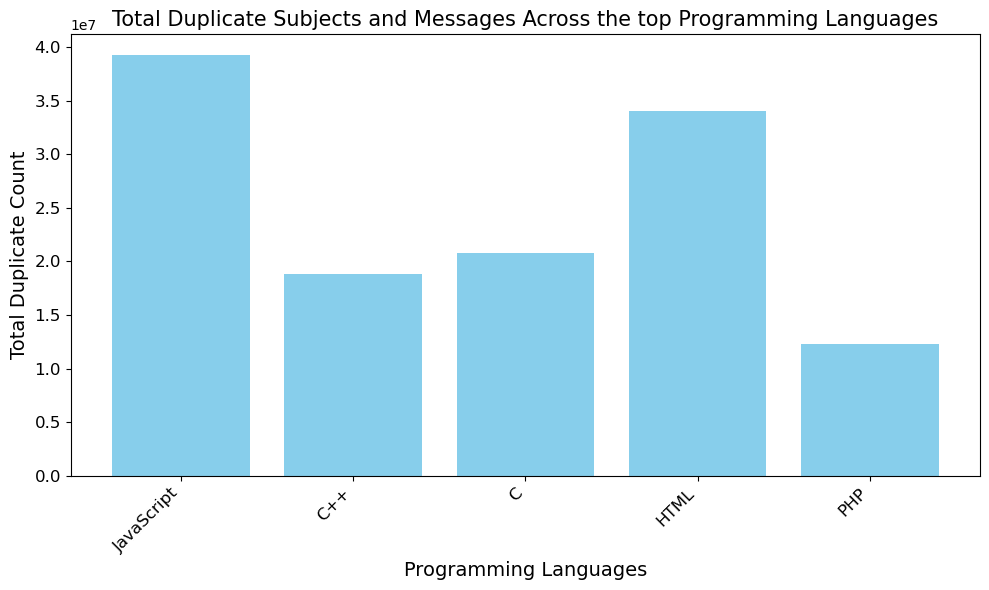

In [20]:
aggregate_counts_pandas = aggregate_counts_df.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(aggregate_counts_pandas['language_name'], aggregate_counts_pandas['total_duplicate_count'], color='skyblue')
plt.xlabel('Programming Languages', fontsize=14)
plt.ylabel('Total Duplicate Count', fontsize=14)
plt.title('Total Duplicate Subjects and Messages Across the top Programming Languages', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()